<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<img src = "https://github.com/Jangrae/img/blob/master/mobile2.png?raw=true" width=800 align="left"/>

# 실습 내용

- Random Search로 Decision Tree 알고리즘 모델을 튜닝합니다.

# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

In [2]:
# 데이터 읽어오기
path = 'https://raw.githubusercontent.com/jangrae/csv/master/mobile.csv'
data = pd.read_csv(path)

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [3]:
# 상위 몇 개 행 확인
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,2,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,3,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,4,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,5,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0


In [4]:
# 기술통계 확인
data.describe()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,CHURN
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,0.502400,80281.447750,85.979550,23.898650,493155.264250,389.615100,8.000700,6.002250,0.492600
std,5773.647028,0.500007,41680.586319,85.992324,26.816645,252407.884692,213.820682,8.925418,4.402558,0.499958
min,1.000000,0.000000,20007.000000,-2.000000,0.000000,150002.000000,130.000000,0.000000,1.000000,0.000000
25%,5000.750000,0.000000,42217.000000,0.000000,0.000000,263714.250000,219.000000,1.000000,2.000000,0.000000
50%,10000.500000,1.000000,75366.500000,59.000000,14.000000,452259.500000,326.000000,4.000000,5.000000,0.000000
75%,15000.250000,1.000000,115881.750000,179.000000,41.000000,702378.000000,533.250000,15.000000,10.000000,1.000000
max,20000.000000,1.000000,159983.000000,335.000000,89.000000,999996.000000,899.000000,29.000000,15.000000,1.000000


# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) 변수 제거**

In [5]:
# 제거 대상: id
drop_col = 'id'

# 변수 제거
data.drop(drop_col, axis=1, inplace=True)

# 확인
data

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,153252,0,23,368403,597,1,6,very_sat,little,actively_looking_into_it,0
19996,1,107126,71,82,237397,609,5,2,very_sat,very_little,no,0
19997,0,78529,0,66,172589,275,0,2,unsat,very_high,considering,1
19998,0,78674,47,41,572406,288,4,2,very_unsat,little,considering,1


**2) x, y 분리**

In [6]:
# Target 설정
target='CHURN'

# 데이터 분리
x = data.drop(target, axis=1)
y = data.loc[:, target]

**3) 가변수화**

In [7]:
# 가변수화 대상: REPORTED_SATISFACTION, REPORTED_USAGE_LEVEL, CONSIDERING_CHANGE_OF_PLAN
dum_cols = ['REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN']

# 가변수화
x = pd.get_dummies(x, dum_cols, drop_first=True, dtype=int)

# 확인
x

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,0,31953,0,6,313378,161,0,4,0,1,0,0,0,1,0,0,0,0,1,0
1,1,36147,0,13,800586,244,0,6,0,1,0,0,0,1,0,0,1,0,0,0
2,1,27273,230,0,305049,201,16,15,0,1,0,0,0,0,0,1,0,0,0,1
3,0,120070,38,33,788235,780,3,2,0,1,0,0,0,0,1,0,1,0,0,0
4,1,29215,208,85,224784,241,21,1,0,0,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,153252,0,23,368403,597,1,6,0,0,1,0,0,1,0,0,0,0,0,0
19996,1,107126,71,82,237397,609,5,2,0,0,1,0,0,0,0,1,0,0,1,0
19997,0,78529,0,66,172589,275,0,2,0,1,0,0,0,0,1,0,1,0,0,0
19998,0,78674,47,41,572406,288,4,2,0,0,0,1,0,1,0,0,1,0,0,0


**4) 학습용, 평가용 데이터 분리**

In [8]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

# 4.성능 예측

- k-Fold Cross Validation을 사용해 모델의 성능을 예측합니다.

In [9]:
# 불러오기
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
# 선언하기
tree_model = DecisionTreeClassifier(random_state=1)

In [22]:
# 성능예측
cv_score = cross_val_score(tree_model, x_train, y_train, cv=10, scoring='accuracy')

In [23]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.60785714 0.61357143 0.63571429 0.61785714 0.61571429 0.61285714
 0.64       0.60785714 0.61642857 0.62071429]
0.6188571428571429


# 5.모델 튜닝


- Random Search로 튜닝을 진행합니다.

**1) 모델 튜닝**

In [26]:
# 파라미터 선언
  # max_depth
param = {'max_depth': range(1, 51)}

# Random Search 선언
  # cv=5
  # n_iter=20
  # scoring='accuracy'
model = RandomizedSearchCV(tree_model, param, cv=5, n_iter=20, scoring='accuracy')

In [27]:
# 학습하기
model.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
                   n_iter=20, param_distributions={'max_depth': range(1, 51)},
                   scoring='accuracy')

**2) 결과 확인**

In [29]:
# mean_test_score 확인
print(model.cv_results_['mean_test_score'])

[0.69742857 0.61792857 0.61521429 0.62078571 0.62442857 0.64414286
 0.61521429 0.61457143 0.61521429 0.65785714 0.66828571 0.61742857
 0.61735714 0.61521429 0.69621429 0.61914286 0.65592857 0.61814286
 0.63342857 0.61685714]


In [32]:
# 최적 파라미터
print(model.best_params_)

{'max_depth': 7}


In [34]:
# 최고 성능
print(model.best_score_)

0.6974285714285715


**3) 변수 중요도**

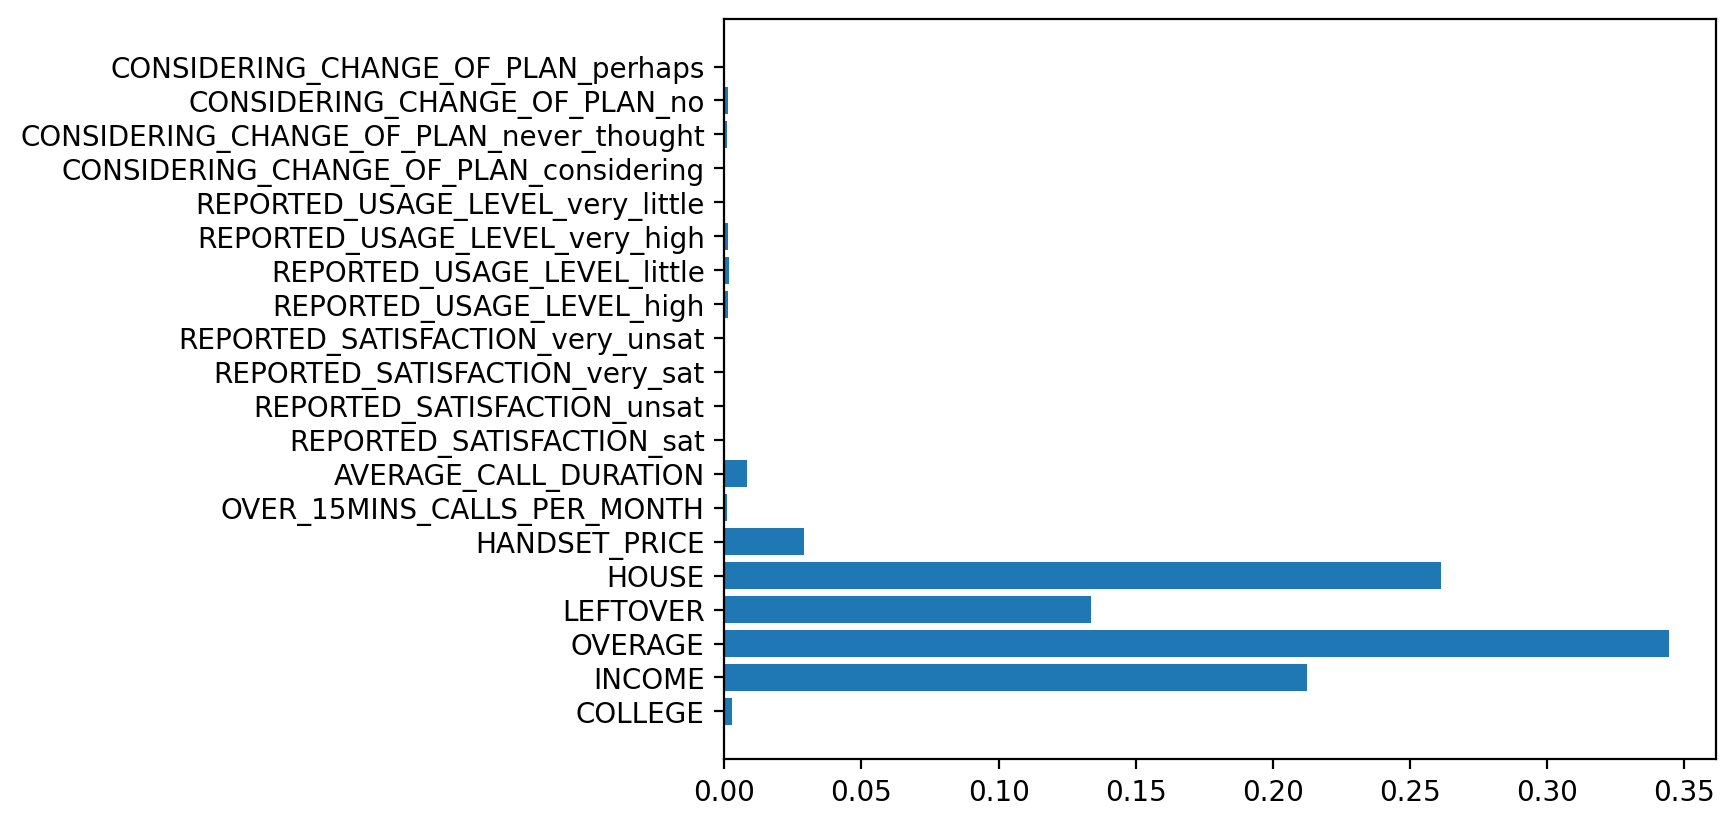

In [39]:
# 변수 중요도
plt.barh(y=list(x), width=model.best_estimator_.feature_importances_)
plt.show()

# 6.성능 평가

- 학습을 통해 예상한 성능과 실제 평가에 따른 성능은 차이가 있을 수 있습니다.
- 예선전에서 성적이 좋았다고 본선에서도 성적이 좋다고 보장할 수는 없겠지요?

In [37]:
# 예측하기
y_pred=  model.predict(x_test)

In [38]:
# 평가하기
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1948 1117]
 [ 676 2259]]
              precision    recall  f1-score   support

           0       0.74      0.64      0.68      3065
           1       0.67      0.77      0.72      2935

    accuracy                           0.70      6000
   macro avg       0.71      0.70      0.70      6000
weighted avg       0.71      0.70      0.70      6000

